In [332]:
import numpy as np 
import torch 
import torch.nn as nn 
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 
from tqdm import trange 
from scipy.sparse.csgraph import connected_components

In [333]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
torch.set_default_device(device) 
torch.set_default_dtype(torch.float64) # Numerical stability 

In [361]:
class Graph: 
    
    def __init__(self, max_edges, warehouse_size, batch_size): 
        self.S = torch.zeros((batch_size, warehouse_size, warehouse_size)) # adjacency matrix (batch_size, n, n)
        self.batch_size = batch_size 
        self.batch_ids = torch.arange(self.batch_size) 
        self.max_edges = max_edges # Maximum number of edges in the graph
        self.stopped = torch.zeros((self.batch_size,)) # Whether the generative process is finished 
        self.global_stop = False  # Global stopping flag
        

    @torch.no_grad() 
    def apply(self, indices, stop_action): 
        rows, cols = indices[:, 0], indices[:, 1]
        for i in range(self.batch_size):
            if not self.stopped[i]:
                if stop_action[i]:  # Handle stop action
                    self.stopped[i] = 1

                if not (rows[i] == cols[i]) and self.stopped[i] == 0:
                    self.S[i, rows[i], cols[i]] = 1
                    self.S[i, cols[i], rows[i]] = 1

                # Stop adding edges if the maximum number is reached
                if (self.S[i].sum())/2 >= self.max_edges:
                    self.stopped[i] = 1
        
        # self.global_stop = self.stopped.all()
        # if self.global_stop:
        #     print("Global stop")
        
        return torch.tensor([self.global_stop] * self.batch_size)

In [362]:
class ForwardPolicy(nn.Module): 
    masked_value = -1e5 # To mask unwanted actions (e.g., adding an edge twice)  
    eps = .3 # For off-policy exploration 

    def __init__(self, warehouse_size, hidden_dim):
        super(ForwardPolicy, self).__init__() 
        self.warehouse_size = warehouse_size 
        self.mlp = nn.Sequential(
            nn.Linear((warehouse_size) * (warehouse_size), hidden_dim), nn.LeakyReLU(), 
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(), 
            nn.Linear(hidden_dim, (warehouse_size) *(warehouse_size) + 1))  # +1 for stop action
    
    def forward(self, state: Graph):
        S = state.S.clone().view(state.batch_size, -1) 
        rep = self.mlp(S) 
        # Mask the already added values 
        rep[:, :-1] = (1 - S) * rep[:, :-1] + S * self.masked_value
        policy = torch.softmax(rep, dim=-1)

        # Sample actions from an exploratory policy 
        eps = 0. if not self.training else self.eps # off-policy only during training 
        unf_policy = (1 - S) / (1 - S).sum(dim=1, keepdims=True)  # edge policy
        unf_policy = torch.cat([unf_policy, torch.zeros((state.batch_size, 1))], dim=1) # stop action policy
        exp_policy = policy * (1 - eps) + unf_policy * eps  # exploratory policy
        actions = torch.multinomial(exp_policy, num_samples=1, replacement=True)
        actions = actions.squeeze() 
        
        # convert flat index back to 2D index and handle stop action
        stop_action = actions == (self.warehouse_size * self.warehouse_size)
        actions_2d = torch.stack([actions // (self.warehouse_size), actions % (self.warehouse_size)], dim=1)
        
        return actions_2d, stop_action, torch.log(policy[state.batch_ids, actions])

class BackwardPolicy(nn.Module): 

    def forward(self, state, actions): 
        S = state.S.clone().view(state.batch_size, -1)
        # The backward policy is fixed as uniform 
        return - torch.log(S.sum(dim=1)) 

In [363]:
class LogReward(nn.Module):
    def __init__(self, warehouse_size, max_edges, seed=42, device='cpu'):
        super(LogReward, self).__init__()
        self.device = device
        self.max_edges = max_edges
        self.rewards = torch.log(torch.arange(1, max_edges + 1, device=self.device).float())

    @torch.no_grad()
    def forward(self, state):
        S = state.S.clone()
        num_edges = (S.sum(dim=(1, 2)) / 2).int()
        log_rewards = self.rewards[num_edges - 1]
        return log_rewards.to(self.device)


In [364]:
class GFlowNet(nn.Module): 

    def __init__(self, forward_policy, backward_policy, log_reward): 
        super(GFlowNet, self).__init__() 
        self.forward_policy = forward_policy
        self.backward_policy = backward_policy 
        self.log_reward = log_reward 

        self.log_partition_function = nn.Parameter(torch.randn((1,)).squeeze(), requires_grad=True) 
            
    def forward(self, batch_state): 
        # We could implement different losses induced by different balance conditions 
        return self._trajectory_balance(batch_state) 

    def _trajectory_balance(self, state): 
        loss = torch.zeros((state.batch_size,), requires_grad=True) 

        while (state.stopped < 1).any(): 
            # Sample an action for each batch 
            actions, stop_action, forward_log_prob = self.forward_policy(state) 
            
            # Apply the actions; the mask indicates which states are completed 
            mask = state.apply(actions, stop_action) 
            
            # Compute the backward transition probabilities 
            backward_log_prob = self.backward_policy(state, actions) 
            
            # Update the loss 
            loss = loss + torch.where(mask, (forward_log_prob.squeeze() - backward_log_prob.squeeze()), 0.) 

        loss = loss + (self.log_partition_function - self.log_reward(state)) 
        return (loss * loss).mean()

    @torch.no_grad()
    def sample(self, state):
        while (state.stopped < 1).any():
            actions, stop_action, _ = self.forward_policy(state)
            state.apply(actions, stop_action)
        return state


In [365]:
warehouse_size = 10
max_edges = 10

log_reward = LogReward(warehouse_size, max_edges)
forward_policy = ForwardPolicy(warehouse_size=warehouse_size, hidden_dim=64)
backward_policy = BackwardPolicy()
gflownet = GFlowNet(forward_policy, backward_policy, log_reward)

optimizer = torch.optim.AdamW([
    # We must use different learning rates to ensure convergence
    {'params': gflownet.forward_policy.parameters(), 'lr': 1e-3}, 
    {'params': gflownet.log_partition_function, 'lr': 1e-1} 
]) 

epochs = 100
batch_size = 256 
losses = []

for epoch in (pbar := trange(epochs)): 
    optimizer.zero_grad() 
    env = Graph(max_edges=max_edges, warehouse_size=warehouse_size, batch_size=batch_size) 
    loss = gflownet(env) 
    losses.append(loss.item())
    loss.backward() 
    optimizer.step() 
    pbar.set_postfix(loss=loss.item())


100%|██████████| 100/100 [00:10<00:00,  9.11it/s, loss=0.0594]


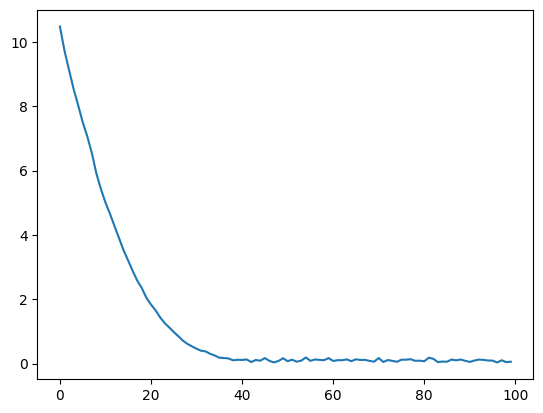

In [366]:
# plot the loss
plt.plot(losses)

In [358]:
gflownet.eval() 
samples = list() 
rewards = list() 
for _ in trange(int(5)): 
    # Sample from the learned distribution 
    env = Graph(max_edges, warehouse_size, batch_size) 
    env = gflownet.sample(env)
    samples.append(env.S) 
    rewards.append(log_reward(env)) 

samples = torch.cat(samples).cpu()  # Use torch.cat instead of torch.vstack
rewards = torch.cat(rewards).cpu()  # Use torch.cat instead of torch.hstack
samples.shape

100%|██████████| 5/5 [00:00<00:00,  9.97it/s]


torch.Size([1280, 10, 10])

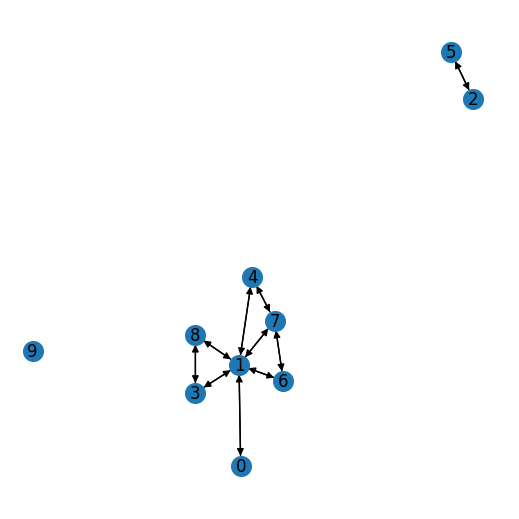

In [359]:
samples_int = samples.int()
samples_np = samples_int.numpy()

G = nx.from_numpy_array(samples_np[1], create_using=nx.DiGraph)
plt.figure(figsize=(5, 5))
# draw directed graph
nx.draw(G, with_labels=True, node_size=200) 
plt.show()

Text(0, 0.5, 'Frequency')

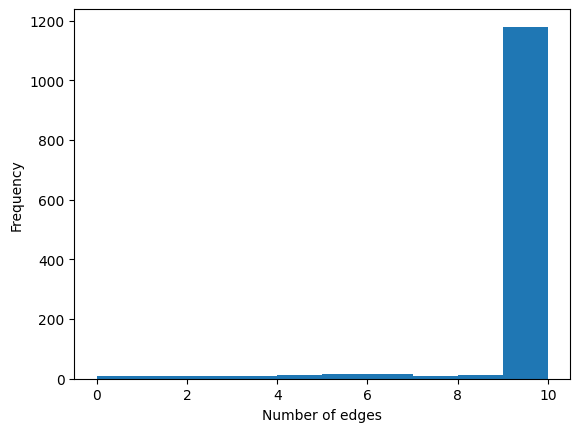

In [360]:
plt.hist(samples_np.sum(axis=(1, 2)) / 2, bins=range(warehouse_size + 1))
plt.xlabel('Number of edges')
plt.ylabel('Frequency')

(array([17., 21., 17., 16., 12., 14., 10., 11., 21.,  0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

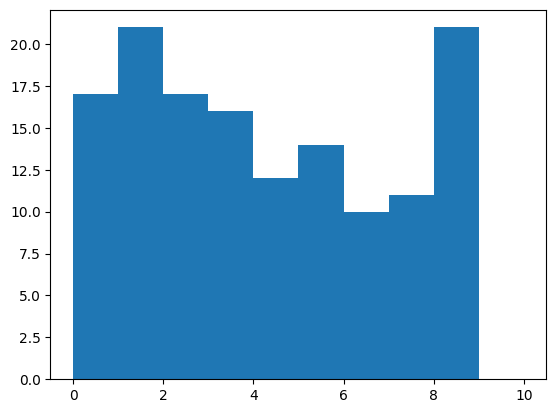

In [327]:
# remove samples with 9 edges
samples = samples[(samples_np.sum(axis=(1, 2)) / 2) < 9]
# plot histogram of these samples
plt.hist(samples.sum(axis=(1, 2)) / 2, bins=range(warehouse_size + 1))
